In [7]:
# required imports
from nltk.classify import accuracy, NaiveBayesClassifier
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction import text 
from textblob import TextBlob

from sklearn import svm, metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
import time




In [8]:
# feature definition is loaded from pickled
with open('global_features.pickle', 'rb') as f:
    global_features = pickle.load(f)

In [9]:
# some common functions 

# used to avoid accessing the global features var directly
def get_features():
    return global_features

# used to remove stopwords from a phrase
def get_clean_phrase(phrase):
    return ' '.join(word for (word) in phrase.split() if word not in text.ENGLISH_STOP_WORDS)

In [10]:
# functions to generate vectors and calculate scores

def generate_vector(phrase):
    vector = {}
    value = 0
    features = get_features()
    for feature_type, feature_names in features.items():
        for feature_name in feature_names:
            key = "{}({})".format(feature_type, feature_name)
            feature_data = {}
            value = get_similarity_score_v4(feature_name, phrase)
            feature_data[key] = value
            vector.update(feature_data)
    return vector


# score is calculated with 3 possible values:
# - 0 if similarity < 0.3
# - 1 if similarity >= 0.3 and < 0.7
# - 2 if similarity >= 0.7
def get_similarity_score_v4(feature, phrase):
    feature_synsets = wn.synsets(feature)
    # we use the first definition
    feature_synset = feature_synsets[0]
    score = 0
    bscore = 0
    for (word) in phrase.split():
        phrase_word_synsets = wn.synsets(word)
        if (len(phrase_word_synsets) > 0):
            cur = feature_synset.wup_similarity(phrase_word_synsets[0])
            cur = 0 if cur is None else cur
        else:
            cur = 0
        score = cur if cur > score else score
    if score >= 0.7:
        bscore = 2
    elif (score < 0.7 and score >=0.3):
        bscore = 1
    else:    
        bscore = 0
    return bscore

In [11]:

# sample vector generation

# obtain a phrase
sample_phrases = []
sample_phrases.append("i honestly do not feel discouraged today as i usually do")
sample_phrases.append("i feel energetic and excited to see my results at the end of the week")
sample_phrases.append("i cant help to also feel a little restless")
sample_phrases.append("felt anger when at the end of telephone call")



# we iterate over phrases
for sample_phrase in sample_phrases:
    print(sample_phrase)    
    sample_phrase_clean = get_clean_phrase(sample_phrase)
    print(sample_phrase_clean)
    sample_vector = generate_vector(sample_phrase_clean)
    print(sample_vector)
    print("\n")

i honestly do not feel discouraged today as i usually do
honestly feel discouraged today usually
{'origin(pleasant)': 0, 'origin(wellness)': 1, 'origin(setback)': 1, 'origin(frustration)': 1, 'origin(adversity)': 1, 'origin(danger)': 1, 'origin(stimulus)': 1, 'origin(unexpected)': 0, 'origin(intensity)': 1, 'consequence(smile)': 1, 'consequence(interaction)': 1, 'consequence(creativity)': 1, 'consequence(refusal)': 1, 'consequence(misfortune)': 1, 'consequence(weakness)': 1, 'consequence(destroy)': 1, 'consequence(aggressiveness)': 1, 'consequence(hostile)': 0, 'consequence(obsession)': 1, 'consequence(panic)': 1, 'consequence(phobia)': 1, 'consequence(anxiety)': 1, 'consequence(setback)': 1}


i feel energetic and excited to see my results at the end of the week
feel energetic excited results end week
{'origin(pleasant)': 0, 'origin(wellness)': 0, 'origin(setback)': 1, 'origin(frustration)': 0, 'origin(adversity)': 0, 'origin(danger)': 1, 'origin(stimulus)': 1, 'origin(unexpected)': 0

In [12]:
# dataset is loaded into different dataframes
df_test = pd.read_csv("data/test.txt", sep=";", names=['phrase', 'feeling'])
df_train = pd.read_csv("data/train.txt", sep=";", names=['phrase', 'feeling'])
df_val = pd.read_csv("data/val.txt", sep=";", names=['phrase', 'feeling'])

# dataframes are joined
df = pd.concat([df_test, df_train, df_val])


# remove "love" feeling as we do not have features for it
data_without_love = df[df['feeling']!= 'love'] 

# we print the phrase count for each feeling
print(data_without_love.groupby(['feeling']).agg(['count']))


         phrase
          count
feeling        
anger      2709
fear       2373
joy        6761
sadness    5797
surprise    719


In [13]:

# since the min amount of phrases is 719 for one feeling
# we create a subset to avoid overtraining
# and by doing this, we balance the dataset
data_filtered = pd.concat([data_without_love[data_without_love['feeling']== 'anger'].sample(720), \
                          data_without_love[data_without_love['feeling']== 'fear'].sample(720), \
                          data_without_love[data_without_love['feeling']== 'joy'].sample(720), 
                          data_without_love[data_without_love['feeling']== 'sadness'].sample(720),
                          data_without_love[data_without_love['feeling']== 'surprise']])
    
#data_filtered = data_without_love
print(data_filtered.groupby(['feeling']).agg(['count']))

         phrase
          count
feeling        
anger       720
fear        720
joy         720
sadness     720
surprise    719


In [14]:
# features are extracted

all_vectors = []

# used to measure time used by exctraction process
tic = time.perf_counter()
    
for index, row in data_filtered.iterrows():
    phrase = row['phrase']
    feeling = row['feeling']
    #print(phrase)
    phrase_clean = get_clean_phrase(phrase)
    vector = generate_vector(phrase_clean)
    all_vectors.append((vector, feeling))


toc = time.perf_counter()

print(f"Features extracted in {toc - tic:0.2f} seconds")
print("\n")

# two random vectors are printed to validate
random.shuffle(all_vectors)
for vector in all_vectors[0:2]:
    print(vector)
    print("\n")

print("Total vectors obtained: ")
print(len(all_vectors))

Features extracted in 238.78 seconds


({'origin(pleasant)': 0, 'origin(wellness)': 1, 'origin(setback)': 1, 'origin(frustration)': 1, 'origin(adversity)': 1, 'origin(danger)': 1, 'origin(stimulus)': 1, 'origin(unexpected)': 0, 'origin(intensity)': 1, 'consequence(smile)': 1, 'consequence(interaction)': 2, 'consequence(creativity)': 1, 'consequence(refusal)': 1, 'consequence(misfortune)': 1, 'consequence(weakness)': 1, 'consequence(destroy)': 1, 'consequence(aggressiveness)': 1, 'consequence(hostile)': 2, 'consequence(obsession)': 1, 'consequence(panic)': 2, 'consequence(phobia)': 1, 'consequence(anxiety)': 1, 'consequence(setback)': 1}, 'surprise')


({'origin(pleasant)': 0, 'origin(wellness)': 1, 'origin(setback)': 1, 'origin(frustration)': 1, 'origin(adversity)': 1, 'origin(danger)': 2, 'origin(stimulus)': 1, 'origin(unexpected)': 0, 'origin(intensity)': 1, 'consequence(smile)': 1, 'consequence(interaction)': 1, 'consequence(creativity)': 1, 'consequence(refusal)': 1, 'consequence(m

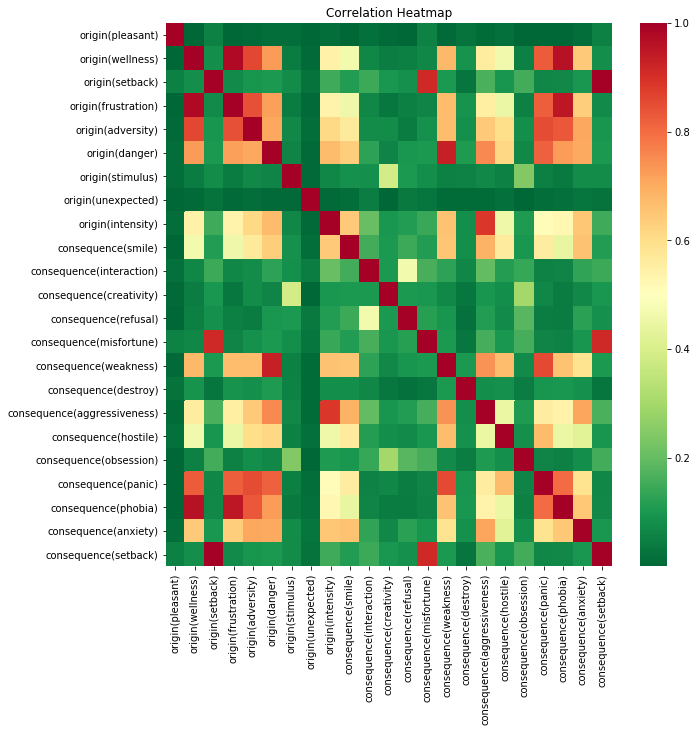

In [15]:
# correlation matrix is obtained

# to get vals from vectors
def get_vals(dicti):
    tot = []
    for test in dicti:
        ar = []
        for k, v in test.items():
            ar.append(v)
        tot.append(ar)
    return tot

# to get vals from vectors
def get_col_names(dicti):
    ar = []
    for k, v in dicti[0].items():
        ar.append(k)
    return ar

data = [vector for (vector, emotion) in all_vectors]
value_data = get_vals(data)
values_dataframe = pd.DataFrame(data=value_data, columns=get_col_names(data))

# absolute value to avoid (-1, 1) range in the graph 
value_correlation = values_dataframe.corr().abs()

# first an initial heatmap to visulize correlation
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(value_correlation, cmap='RdYlGn_r')
plt.title('Correlation Heatmap')
plt.show()



In [16]:
# selecting features (columns) with correlation under 0.4 

correlation_threshold = 0.4

not_correlated =~(value_correlation.mask(np.tril(np.ones([len(value_correlation)]*2, dtype=bool))).abs() > correlation_threshold).any()
uncorrlenated_columns = not_correlated.loc[not_correlated[not_correlated.index] == True].index
print("Uncorrelated columns:")
print(uncorrlenated_columns)
print("Total resultant columns:")
print(len(uncorrlenated_columns))



Uncorrelated columns:
Index(['origin(pleasant)', 'origin(wellness)', 'origin(setback)',
       'origin(stimulus)', 'origin(unexpected)', 'consequence(interaction)',
       'consequence(creativity)', 'consequence(destroy)',
       'consequence(obsession)'],
      dtype='object')
Total resultant columns:
9


In [17]:
# classifier evaluation

# to get vals from vectors
def get_vals_from_vectors(dicti):
    tot = []
    for test in dicti:
        ar = []
        for k, v in test.items():
            ar.append(v)
        tot.append(ar)
    return tot

# to get only valid features in vectors
def get_clean_vectors():
    clean_vectors = []
    for (vector, emotion) in all_vectors:
        new_vector = {}
        for k,v in vector.items():
            if k in uncorrlenated_columns:
                new_vector[k] = v
        clean_vectors.append(new_vector)
    return clean_vectors

 # 70% training and 30% test
data = get_clean_vectors()
label = [emotion for (vector, emotion) in all_vectors]
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3,random_state=109)

# data handling
Encoder = LabelEncoder()
y_train_enc = Encoder.fit_transform(y_train)
y_test_enc = Encoder.fit_transform(y_test)


X_train_num = get_vals_from_vectors(X_train)
X_test_num = get_vals_from_vectors(X_test)


#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel
#Train the model using the training sets
clf.fit(X_train_num, y_train_enc)
#Predict the response for test dataset
y_pred = clf.predict(X_test_num)
matrix = confusion_matrix(y_test_enc, y_pred)
# Model Accuracy: how often is the classifier correct?
print("Accuracy SVC:",metrics.accuracy_score(y_test_enc, y_pred))
print("Confusion matrix for SVC:")
print(matrix)
print("\n")

#Create a MLPClassifier Classifier
clf = MLPClassifier()
#Train the model using the training sets
clf.fit(X_train_num, y_train_enc)
#Predict the response for test dataset
y_pred = clf.predict(X_test_num)
matrix = confusion_matrix(y_test_enc, y_pred)
# Model Accuracy: how often is the classifier correct?
print("Accuracy MLPClassifier:",metrics.accuracy_score(y_test_enc, y_pred))
print("Confusion matrix for MLPClassifier:")
print(matrix)
print("\n")

#Create a svm GradientBoostingClassifier
clf = GradientBoostingClassifier()
#Train the model using the training sets
clf.fit(X_train_num, y_train_enc)
#Predict the response for test dataset
y_pred = clf.predict(X_test_num)
matrix = confusion_matrix(y_test_enc, y_pred)
# Model Accuracy: how often is the classifier correct?
print("Accuracy GradientBoostingClassifier:",metrics.accuracy_score(y_test_enc, y_pred))
print("Confusion matrix for GradientBoostingClassifier:")
print(matrix)
print("\n")

#Create a MultinomialNB Classifier
clf = MultinomialNB()
#Train the model using the training sets
clf.fit(X_train_num, y_train_enc)
#Predict the response for test dataset
y_pred = clf.predict(X_test_num)
matrix = confusion_matrix(y_test_enc, y_pred)
# Model Accuracy: how often is the classifier correct?
print("Accuracy MultinomialNB:",metrics.accuracy_score(y_test_enc, y_pred))
print("Confusion matrix for MultinomialNB:")
print(matrix)
print("\n")

#Create a RandomForestClassifier Classifier
clf = RandomForestClassifier() # Linear Kernel
#Train the model using the training sets
clf.fit(X_train_num, y_train_enc)
#Predict the response for test dataset
y_pred = clf.predict(X_test_num)
matrix = confusion_matrix(y_test_enc, y_pred)
# Model Accuracy: how often is the classifier correct?
print("Accuracy RandomForestClassifier:",metrics.accuracy_score(y_test_enc, y_pred))
print("Confusion matrix for RandomForestClassifier:")
print(matrix)
print("\n")



Accuracy SVC: 0.20277777777777778
Confusion matrix for SVC:
[[178   3   2   3  18]
 [188   1   4   8  29]
 [179   3   9   5  27]
 [180   5   1   3  24]
 [172   2   4   4  28]]


Accuracy MLPClassifier: 0.20833333333333334
Confusion matrix for MLPClassifier:
[[150  23  10   3  18]
 [154  28  15   5  28]
 [144  28  15   6  30]
 [160  16  10   4  23]
 [145  21  13   3  28]]


Accuracy GradientBoostingClassifier: 0.20092592592592592
Confusion matrix for GradientBoostingClassifier:
[[72 23 12 12 85]
 [62 31 18 21 98]
 [71 29 16 16 91]
 [72 17 12 16 96]
 [72 22 20 14 82]]


Accuracy MultinomialNB: 0.19444444444444445
Confusion matrix for MultinomialNB:
[[ 82   0   0   0 122]
 [ 75   0   0   0 155]
 [ 81   0   3   0 139]
 [ 82   0   0   0 131]
 [ 85   0   0   0 125]]


Accuracy RandomForestClassifier: 0.21574074074074073
Confusion matrix for RandomForestClassifier:
[[ 96  29   3  48  28]
 [102  38   1  43  46]
 [ 90  33   4  54  42]
 [105  22   2  51  33]
 [ 84  31   4  47  44]]


